In [1]:
%%time
import sys;
#!{sys.executable} -m pip install -r requirements.txt

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


In [2]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print(f'Bucket {bucket} in region {region}')

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 869 ms, sys: 118 ms, total: 987 ms
Wall time: 4.71 s


In [3]:
%%time
import random
import pandas as pd
raw_data_filename = 'fraud-detection.csv'

s3 = boto3.resource('s3', region_name=region)
#s3.Bucket(bucket).download_file(raw_data_filename, raw_data_filename)
percent_to_read=100
fraction_to_read=percent_to_read/100 # Divide by 1000 and not 100 as expected?
df = pd.read_csv('./'+raw_data_filename,  skiprows=lambda i: i>0 and random.random() > fraction_to_read)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print('Length', len(df))
target_col='isFraud'
df

Length 6362620
CPU times: user 11.4 s, sys: 1.46 s, total: 12.8 s
Wall time: 18 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never but `CASH_IN` or `PAYMENT`. Could filter these out.

Counts of each class to determine imbalance.

In [4]:
 
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 8213 ; Not fraud 6354407 ; Total 6362620


Not using `isFlaggedFraud`.

In [5]:
df = df.drop(['isFlaggedFraud'], axis=1)

Plot distribution of positive vs negative, in log scale because of the imbalance

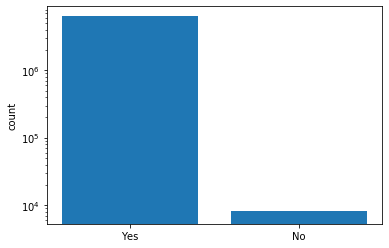

In [6]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
    val_counts=df[target_col].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale="log")
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,target_col)

Scale the numerical values.

In [7]:
#Split numerical from non-numerical
columns = df.columns
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
other_col =[c for c in columns if  c not in numerical_cols]
df_other = df[other_col]

df_num = df[numerical_cols]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
df = pd.concat([df_num, df_other], axis=1)
df = df[columns] # Put back in old order
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0
1,1,PAYMENT,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0
2,1,TRANSFER,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1
3,1,CASH_OUT,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1
4,1,PAYMENT,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,0.264665,C786484425,-0.171108,-0.292442,C776919290,-0.323814,-0.240959,1
6362616,743,TRANSFER,10.153953,C1529008245,1.896491,-0.292442,C1881841831,-0.323814,-0.333411,1
6362617,743,CASH_OUT,10.153953,C1162922333,1.896491,-0.292442,C1365125890,-0.303665,1.403027,1
6362618,743,TRANSFER,1.109765,C1685995037,0.005581,-0.292442,C2080388513,-0.323814,-0.333411,1


Make dummies (onehot) for `type` field.

In [8]:
cols = df.columns.tolist()
cols.remove(target_col)
cols = [target_col] + cols
df = df[cols] # Move target to the left

df_dummies=pd.get_dummies(df['type'],drop_first=True )

df=df.drop(['type'], axis=1)
df = pd.concat([df, df_dummies], axis=1)
 

Use *HashingEncoder* to handle categorical columns with high cardinality. These cannot be onehotted as that would generate too many columns and a too-sparse matrix.

In [9]:
%%time
high_cardinality__categorical_col = ['nameOrig', 'nameDest']
use_hashing_encoder = False
if not use_hashing_encoder:
    print('Dropping high-cardinality categorical columns')
    df=df.drop(high_cardinality__categorical_col, axis=1)
else:
  import category_encoders as ce  
  columns_before = [x for x in df.columns if x not in high_cardinality__categorical_col+[target_col]]

  def make_col_mapping(cols):
    col_mapping = {}
    for c in cols:
        if c[:4]=='col_':
          num = c.split('_')[-1]
          int(num) # check format
          col_mapping[c] = hashencode_this + "_" + num
     
    return col_mapping

  #TODO hashencode in one pass, both columns
  def hashencode(hashencode_this, df, previous_hash_cols):
    for c in df.columns:
        assert c[:4]!="col_",  df.columns
    cpus_in_t2xlarge = 4
    default_max_sample = len(df)/cpus_in_t2xlarge
    max_sample = default_max_sample/2
    ce_hash = ce.HashingEncoder(cols = [hashencode_this],max_sample=max_sample)
    X1 = df.drop([target_col], axis=1)
    y1 = df[target_col]
    with_hashing = ce_hash.fit_transform(X1, y1)
    hashed = with_hashing.drop(columns_before+previous_hash_cols, axis=1)
    generated_cols = [x for x in hashed.columns if x[:4]=='col_']
    col_mapping = make_col_mapping(generated_cols)
    
    hashed = hashed.rename(columns = col_mapping)
    df = pd.concat([y1, X1, hashed], axis=1)
 
    df = df.drop([hashencode_this], axis=1)
    return df, list(col_mapping.values())
 
  previous_hash_cols = []
  for hashencode_this in high_cardinality__categorical_col: 
   df, previous_hash_cols = hashencode(hashencode_this,df,previous_hash_cols)
 

Index(['isFraud', 'step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'], dtype='object')
CPU times: user 944 ms, sys: 293 ms, total: 1.24 s
Wall time: 1.23 s


,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,1,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0,0,1,0
1,0,1,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0,0,1,0
2,1,1,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,0,0,0,1
3,1,1,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,1,0,0,0
4,0,1,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,743,0.264665,-0.171108,-0.292442,-0.323814,-0.240959,1,0,0,0
6362616,1,743,10.153953,1.896491,-0.292442,-0.323814,-0.333411,0,0,0,1
6362617,1,743,10.153953,1.896491,-0.292442,-0.303665,1.403027,1,0,0,0
6362618,1,743,1.109765,0.005581,-0.292442,-0.323814,-0.333411,0,0,0,1


Optionally use *SMOTENC* for unbalanced classes, though we may stick with the XGBoost parameters.

In [10]:

from imblearn.over_sampling import SMOTENC
# Using weighting in XGBOOST instead of SMOTENC
use_smote = False
if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

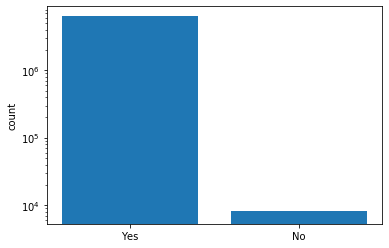

In [11]:
plot_positive_negative_counts(df,target_col)

# Split  with randomization

In [12]:
import numpy as np
len_=len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

Using libSVM for performance.

In [13]:
from sklearn.datasets import dump_svmlight_file   

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

s3 = boto3.resource('s3', region_name=region)#TODO Remove

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

Length of datasets: [('train', 4453834), ('validation', 1272524), ('test', 636262)]


In [14]:
def s3_path(subset):
  return sagemaker.s3_input(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


---
## Train

Our data is now ready to be used to train a XGBoost model. The XGBoost algorithm has many tunable hyperparameters. Some of these hyperparameters are listed below; initially we'll only use a few of them.  

- `max_depth`: Maximum depth of a tree. As a cautionary note, a value too small could underfit the data, while increasing it will make the model more complex and thus more likely to overfit the data (in other words, the classic bias-variance tradeoff).
- `eta`: Step size shrinkage used in updates to prevent overfitting.  
- `eval_metric`: Evaluation metric(s) for validation data. For data sets such as this one with imbalanced classes, we'll use the AUC metric.
- `scale_pos_weight`: Controls the balance of positive and negative weights, again useful for data sets having imbalanced classes.

First we'll set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.  The Estimator object from the Amazon SageMaker Python SDK is a convenient way to set up training jobs with a minimal amount of code.

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)
scale_pos_weight=num_negative / num_positive  
num_positive, num_negative=count_positive_and_negative(df)

print('scale_pos_weight', f'{scale_pos_weight:.1f}')

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=100)


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


scale_pos_weight 773.7


Run the hosted training (`fit`) job.

In [16]:
%%time
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-11-08 15:15:38 Starting - Starting the training job...
2020-11-08 15:15:40 Starting - Launching requested ML instances......
2020-11-08 15:16:46 Starting - Preparing the instances for training...
2020-11-08 15:17:23 Downloading - Downloading input data...
2020-11-08 15:18:00 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[15:18:04] 4453834x10 matrix with 30197900 entries loaded from /opt/ml/input/data/train
[15:18:05] 1272524x10 matrix with 8627360 entries loaded from /opt/ml/input/data/va

---
## Host

Now that we've trained the XGBoost algorithm on our data, we can deploy the trained model to an Amazon SageMaker hosted endpoint with one simple line of code.

In [18]:
import datetime 
model = xgb.create_model()
container_def = model.prepare_container_def(instance_type='ml.m4.xlarge')
model_name = 'fraud' + datetime.datetime.now().isoformat().replace('.','-').replace(':','-')  
print('model_name', model_name)

direct_deploy =true
direct_deploy =true
endpoint_name='fraud-detection-endpoint'

if direct_deploy:
  xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')
else:
  session.create_model(model_name, role, container_def)

  endpoint_config_name = session.create_endpoint_config(name=model_name,
                                                      model_name=model_name,
                                                      initial_instance_count=1,
                                                      instance_type='ml.m5.xlarge')

  client = boto3.client('sagemaker')
  updated_endpoint=client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
  print(updated_endpoint)
  xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sagemaker.Session())


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


model_name fraud2020-11-08T15-34-18-857908


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [19]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [23]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

In [49]:
print ('\nError rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

actual_pos = sum(1 for i in range(len(labels)) if 1==labels[i])
actual_neg = sum(1 for i in range(len(labels)) if 0==labels[i])

pred_pos = sum(1 for i in range(len(preds)) if 1==preds[i])
pred_neg = sum(1 for i in range(len(preds)) if 0==preds[i])

true_pos = sum(1 for i in range(len(preds)) if  preds[i]==1==labels[i])
true_neg = sum(1 for i in range(len(preds)) if  preds[i]==0==labels[i])

false_pos=sum(1 for i in range(len(preds)) if  preds[i]==1 and 0==labels[i])
false_neg=sum(1 for i in range(len(preds)) if  preds[i]==0 and 1==labels[i])

recall = true_pos/(true_pos+false_neg)
precision = true_pos/(true_pos+false_pos)
 
assert true_pos + false_neg==actual_pos
assert true_neg + false_pos==actual_neg
#print('pred_pos', pred_pos,'pred_neg', pred_neg)

assert len(preds)==len(labels)

#print(len(preds), 'predictions and labels')

#print('actual_pos', actual_pos, 'actual_neg', actual_neg)
assert actual_pos+actual_neg==len(labels)
                   
#print('true_pos', true_pos, 'false_pos', false_pos)
#assert  true_pos+false_pos == pred_pos

#print('true_neg', true_neg, 'false_neg', false_neg )
assert true_neg+false_neg== pred_neg

#print('pred_pos+pred_neg',pred_pos+pred_neg)
assert pred_pos+pred_neg==len(preds)

print(f'Recall={recall:.2f}')
print(f'Precision={precision:.2f}')
 


Error rate=0.017515
Recall=0.99
Precision=0.07


Show confusion matrix.

In [21]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

col_0,0,1
row_0,,
0,624296,11139
1,5,822


Clean up to save money

In [22]:
session.delete_endpoint(xgb_predictor.endpoint)